In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import wandb

pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 200)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kazadaevms. Use `wandb login --relogin` to force relogin


True

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
from library.load import TRADING_DAYS_IN_YEAR
from library.dataset import load_train_test_dataset, Observation
from library.correlations import get_correlation_matrices, N_REMAINING_COMPONENTS, CorrelationMatrices


observations_train, observations_test, df_price_train, df_price_test = load_train_test_dataset()
correlations_train, correlations_test = get_correlation_matrices(observations_train, True, N_REMAINING_COMPONENTS, N_REMAINING_COMPONENTS), get_correlation_matrices(observations_test, True, N_REMAINING_COMPONENTS, N_REMAINING_COMPONENTS)

Original number of tickers: 246
Drop tickers: ['IRAO']
Start date = 2013-12-16
Filtered number of tickers: 30
Stocks: ['AFLT', 'ALRS', 'GCHE', 'HYDR', 'LKOH', 'LSRG', 'MGNT', 'MOEX', 'MRKC', 'MRKP', 'MSNG', 'MSRS', 'MTLR', 'MTLRP', 'MTSS', 'NVTK', 'PHOR', 'PIKK', 'POLY', 'RTKM', 'RTKMP', 'SBER', 'SBERP', 'TATN', 'TATNP', 'TGKA', 'TRMK', 'TRNFP', 'UTAR', 'VTBR']
DataFrame size after merge: 2255
DataFrame size after removing some years: 1753

2015 year: 246 observations
2016 year: 252 observations
2017 year: 252 observations
2018 year: 246 observations
2019 year: 252 observations
2020 year: 250 observations
2021 year: 255 observations

Train: 1010. Test: 472. Test ratio: 0.3184885290148448


In [4]:
N_ASSETS = 30
assert observations_train[0].df_price_train.shape[1] == N_ASSETS

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
from enum import Enum, auto
from torch.utils.data import Dataset, DataLoader


class TargetType(Enum):
    NEXT_RETURN = auto()  # vector of returns if we invest in stocks now
    NEXT_RETURNS = auto()


class FeaturesType(Enum):
    MEAN_RETURNS = auto()
    STDS = auto()
    CORRELATION_MATRIX = auto()


class PortfolioDataset(Dataset):
    def __init__(self, observations: list[Observation], correlations: CorrelationMatrices, target_type: TargetType, features_types: list[FeaturesType], features_types_params: dict[str, str]):
        # save data
        assert len(observations) == len(correlations.returns)
        self.observations = observations
        self.correlations = correlations
        self.target_type = target_type
        self.features_types = features_types
        self.features_types_params = features_types_params
        self.length = len(observations)

        # construct features and targets
        self.features = self._compute_features()
        self.targets = self._compute_targets()

    def _compute_targets(self) -> list[torch.tensor]:
        targets = []
        for i in range(self.length):
            observation = self.observations[i]
            if self.target_type == TargetType.NEXT_RETURN:
                target = self._pandas_to_tensor(observation.next_returns)
            elif self.target_type == TargetType.NEXT_RETURNS:
                target = self._pandas_to_tensor(observation.df_returns_test)
            else:
                assert False, 'Unreachable'
            targets.append(target)
        return targets

    def _compute_features(self) -> list[torch.tensor]:
        result = []
        for i in range(self.length):
            features_list = []
            for feature_type in self.features_types:
                if feature_type == FeaturesType.MEAN_RETURNS:
                    features = self._pandas_to_tensor(self.correlations.returns[i].mean(axis=0))
                elif feature_type == FeaturesType.STDS:
                    features = self._numpy_to_tensor(self.correlations.stds[i])
                elif feature_type == FeaturesType.CORRELATION_MATRIX:
                    features = self._get_correlation_matrix(i)
                else:
                    assert False, 'Unreachable'
                features_list.append(features)
            features = torch.cat([f.reshape(-1) for f in features_list])
            result.append(features)
        return result

    def _get_correlation_matrix(self, index: int) -> pd.DataFrame:
        corr_type = self.features_types_params['corr_type']
        if corr_type == 'Sigma':
            return self._pandas_to_tensor(self.correlations.Sigmas[index])
        elif corr_type == 'Sigma_denoised':
            return self._pandas_to_tensor(self.correlations.Sigmas_denoised[index])
        elif corr_type == 'Sigma_detoned':
            return self._pandas_to_tensor(self.correlations.Sigmas_detoned[index])
        elif corr_type == 'Sigma_detoned_denoised':
            return self._pandas_to_tensor(self.correlations.Sigmas_detoned_denoised[index])
        elif corr_type == 'Sigma_svd':
            vectors_numbers = self.features_types_params['vectors_numbers']
            vectors = self.correlations.singular_vectors[index][vectors_numbers]
            values = self.correlations.singular_values[index][vectors_numbers]
            return self._numpy_to_tensor(np.concatenate((vectors.reshape(-1), values.reshape(-1))))
        else:
            assert False, 'Unreachable'

    @staticmethod
    def _pandas_to_tensor(array):
        return torch.from_numpy(array.values.astype(np.float32))

    @staticmethod
    def _numpy_to_tensor(array):
        return torch.from_numpy(array.astype(np.float32))

    def __getitem__(self, index: int) -> tuple[torch.tensor, torch.tensor]:
        return self.features[index], self.targets[index]

    def __len__(self):
        return self.length

In [7]:
def get_loaders(dataset_params: list, shuffle_train: bool = True, batch_size: int = 32):
    train_dataset = PortfolioDataset(observations_train, correlations_train, *dataset_params)
    val_dataset = PortfolioDataset(observations_test, correlations_test, *dataset_params)
    print(f'Train: {len(train_dataset)}. Test: {len(val_dataset)}')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    tmp_features, tmp_targets = next(iter(train_loader))
    print(f'Features: {tmp_features.size()}. Targets: {tmp_targets.size()}')
    return train_loader, val_loader

In [8]:
from torch import nn


class ReturnCriterion(nn.Module):
    def forward(self, weights, returns):
        return -(weights * returns).sum(dim=-1).mean()  # maximize return

    def print_metric(self, train_loss: float, val_loss: float, baseline_loss):
        train_loss = -train_loss * 100
        val_loss = -val_loss * 100
        baseline_loss = -baseline_loss * 100
        print(f'Day return: val={val_loss:.4f}%; train={train_loss:.4f}%; baseline={baseline_loss:.4f}')
        print(f'Annual return: val={val_loss * TRADING_DAYS_IN_YEAR:.2f}%; train={train_loss * TRADING_DAYS_IN_YEAR:.2f}%; baseline={baseline_loss * TRADING_DAYS_IN_YEAR:.2f}')


class SigmaMinusReturnConstantWeights(nn.Module):
    def __init__(self, q: float, total_mean_returns) -> None:
        super().__init__()
        self.q = q
        self.total_mean_returns = total_mean_returns

    def forward(self, weights, returns):
        # weights: (BATCH_SIZE, N_STOCKS)
        # returns: (BATCH_SIZE, N_DAYS, N_STOCKS)
        portfolio_returns = (returns * weights.unsqueeze(dim=-2)).sum(dim=-1)
        # portfolio_returns: (BATCH_SIZE, N_DAYS)
        if self.total_mean_returns is None:
            mean_returns = portfolio_returns.mean(dim=1)
        else:
            mean_returns = (self.total_mean_returns.unsqueeze(dim=0) * weights).sum(dim=-1)
        stds = portfolio_returns.std(dim=1)
        metric = stds - self.q * mean_returns
        # metric: (BATCH_SIZE,)
        return metric.mean()

    def print_metric(self, train_loss: float, val_loss: float, baseline_loss):
        print(f'SigmaMinusReturnConstantWeights: val={val_loss:.4f}%; train={train_loss:.4f}%; baseline={baseline_loss:.4f}')


class SigmaMinusReturnOnAllData(nn.Module):
    def __init__(self, q: float) -> None:
        super().__init__()
        self.q = q

    def forward(self, weights, returns):
        # weights: (BATCH_SIZE, N_STOCKS)
        # returns: (BATCH_SIZE, N_STOCKS)
        portfolio_returns = (returns * weights).sum(dim=-1)
        # portfolio_returns: (BATCH_SIZE,)
        mean_returns = portfolio_returns.mean()
        stds = portfolio_returns.std()
        metric = stds - self.q * mean_returns
        # metric: (1,)
        return metric

    def print_metric(self, train_loss: float, val_loss: float, baseline_loss):
        print(f'SigmaMinusReturnConstantWeights: val={val_loss:.4f}%; train={train_loss:.4f}%; baseline={baseline_loss:.4f}')


def get_baseline_w_and_returns(train_loader, val_loader) -> tuple:
    baseline_w = torch.full(size=(len(val_loader.dataset), N_ASSETS), fill_value=1 / N_ASSETS)
    val_returns = torch.concat([b[1] for b in val_loader], dim=0)
    train_returns = torch.concat([b[1] for b in train_loader], dim=0)
    total_mean_returns = train_returns[:, 0, :].mean(dim=0) if train_returns.dim() == 3 else None
    return baseline_w, val_returns, total_mean_returns

In [9]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from timeit import default_timer as timer
from library.backtest import Strategy, compare_strategies


def train_loop(model, optimizer, criterion, train_loader) -> float:
    """
    Return Mean metric
    """
    train_loss = 0.0
    model.train()
    for features, targets in train_loader:
        features = features.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.shape[0]
    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def val_loop(model, criterion, val_loader) -> float:
    """
    Return Mean metric
    """
    val_loss = 0.0
    model.eval()
    for features, targets in val_loader:
        features = features.to(device)
        targets = targets.to(device)
        predictions = model(features)
        loss = criterion(predictions, targets)
        val_loss += loss.item() * features.shape[0]
    val_loss /= len(val_loader.dataset)
    return val_loss


def train_nn(model, optimizer, criterion, scheduler, train_loader, val_loader, n_epochs: int, baseline_loss: float, plot_baseline: bool, log_wandb: bool, name: str):
    train_losses, val_losses = [], []

    for epoch in tqdm(range(1, n_epochs + 1)):
        # Train
        start_time = timer()
        train_loss = train_loop(model, optimizer, criterion, train_loader)
        train_losses.append(train_loss)
        train_time = timer() - start_time

        # Validation
        start_time = timer()
        val_loss = val_loop(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_time = timer() - start_time

        # Log lr
        lr = next(iter(optimizer.param_groups))['lr']

        # Scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Log record
        record = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr': lr,
            'train_time': train_time,
            'val_time': val_time,
        }
        if log_wandb:
            wandb.log(record)

        # Plot
        if epoch == n_epochs:
            clear_output()
            criterion.print_metric(train_losses[-1], val_losses[-1], baseline_loss)
            print(f'Train time: {train_time:.3f}s; val time: {val_time:.3f}s')
            if plot_baseline:
                plt.axhline(baseline_loss, linestyle='dashed', label='baseline', color='black')
            plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
            plt.plot(range(1, len(val_losses) + 1), val_losses, label='test')
            plt.title(name)
            plt.ylabel('Metric')
            plt.xlabel('Epoch')
            plt.legend(loc='upper right')
            plt.show()
    if log_wandb:
        wandb.finish()


@torch.no_grad()
def predict_nn(model, loader, observations: list[Observation]):
    model.eval()
    predictions = []
    for features, targets in loader:
        features = features.to(device)
        targets = targets.to(device)
        w = model(features)
        predictions.append(w)
    predictions = torch.cat(predictions, dim=0)
    dates = [observation.df_price_test.index[0] for observation in observations]
    result = pd.DataFrame(predictions.numpy(), index=dates, columns=observations[0].df_price_train.columns)
    assert np.allclose(result.sum(axis=1), 1.0)
    return result


class Net(nn.Module):
    def __init__(self, layer_sizes: list[int]):
        super().__init__()
        args = []
        for i in range(1, len(layer_sizes) - 1):
            args += [nn.Linear(layer_sizes[i - 1], layer_sizes[i]), nn.ReLU()]
        args += [nn.Linear(layer_sizes[-2], layer_sizes[-1])]
        self.net = nn.Sequential(
            *args,
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
LOG_WANDB = False
LR = 1e-3


def get_net(layer_sizes: list[int]):
    print(f'LayerSizes: {layer_sizes}')
    print(f'LR = {LR}')

    model = Net(layer_sizes=layer_sizes).to(device)
    return model


def get_features_size(val_loader):
    return next(iter(val_loader))[0].size()[1]


def get_optimizer_scheduler(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = None
    return optimizer, scheduler


def print_experiment(n_epochs, baseline_loss: float, model, criterion):
    print(f'{n_epochs = }')
    print(f'{baseline_loss = }')
    print(model)
    print(criterion)


def run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, n_epochs, name):
    torch.manual_seed(0)
    try:
        train_nn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=n_epochs, baseline_loss=baseline_loss, plot_baseline=True, log_wandb=LOG_WANDB, name=name)
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        if LOG_WANDB:
            wandb.finish()
    print('Success')
    return model


def get_strategy(model, dataset_params: list, name: str):
    t_loader, v_loader = get_loaders(dataset_params, shuffle_train=False)

    def get_train_w(t_loader=t_loader):
        return predict_nn(model, t_loader, observations_train)

    def get_test_w(v_loader=v_loader):
        return predict_nn(model, v_loader, observations_test)

    return Strategy(
        name=name,
        get_train_w=get_train_w,
        get_test_w=get_test_w,
    )

In [11]:
def get_layer_sizes(features_size: int):
    return [
        [features_size, 50, N_ASSETS],
        [features_size, 50, 50, N_ASSETS],
        [features_size, 80, 50, N_ASSETS],
        [features_size, 80, 60, 40, N_ASSETS],
    ]


# def get_layer_sizes_final(features_size: int):
#     return [features_size, 50, N_ASSETS]


def get_q():
    return [0.0, 0.2, 0.5, 1.0, 3.0, 5.0]

# Experiment 1

Признаки: прошлые средние return и stds

Критерий: ReturnCriterion()


Day return: val=0.0988%; train=0.1595%; baseline=0.0836
Annual return: val=24.91%; train=40.19%; baseline=21.06
Train time: 0.080s; val time: 0.009s


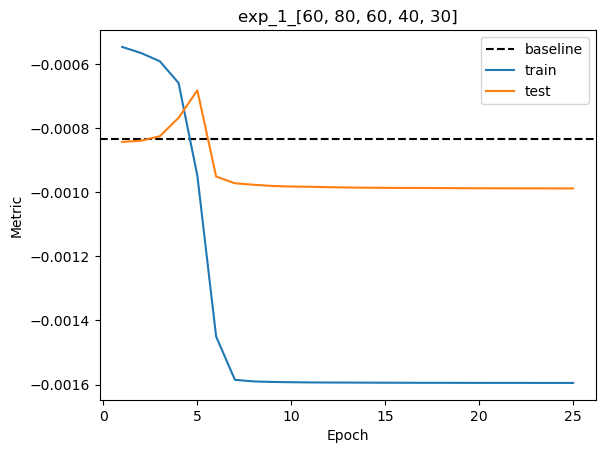

Success
Train: 1010. Test: 472
Features: torch.Size([32, 60]). Targets: torch.Size([32, 30])
exp_1_[60, 50, 30]
                   portfolio_train   baseline_train   portfolio_test    baseline_test
return             38.18% ± 21.56%  13.93% ± 12.00%  18.15% ± 23.04%  21.06% ± 18.24%
sharpe ratio              1.770944         1.161015         0.787674         1.154165
difference         24.25% ± 14.76%    0.00% ± 0.00%  -2.91% ± 11.06%    0.00% ± 0.00%
information ratio         1.643613              NaN        -0.263111              NaN

exp_1_[60, 50, 50, 30]
                   portfolio_train   baseline_train   portfolio_test    baseline_test
return             40.04% ± 26.98%  13.93% ± 12.00%  23.10% ± 24.81%  21.06% ± 18.24%
sharpe ratio              1.483813         1.161015         0.931216         1.154165
difference         26.11% ± 21.06%    0.00% ± 0.00%   2.05% ± 15.03%    0.00% ± 0.00%
information ratio         1.239387              NaN         0.136118              NaN

exp

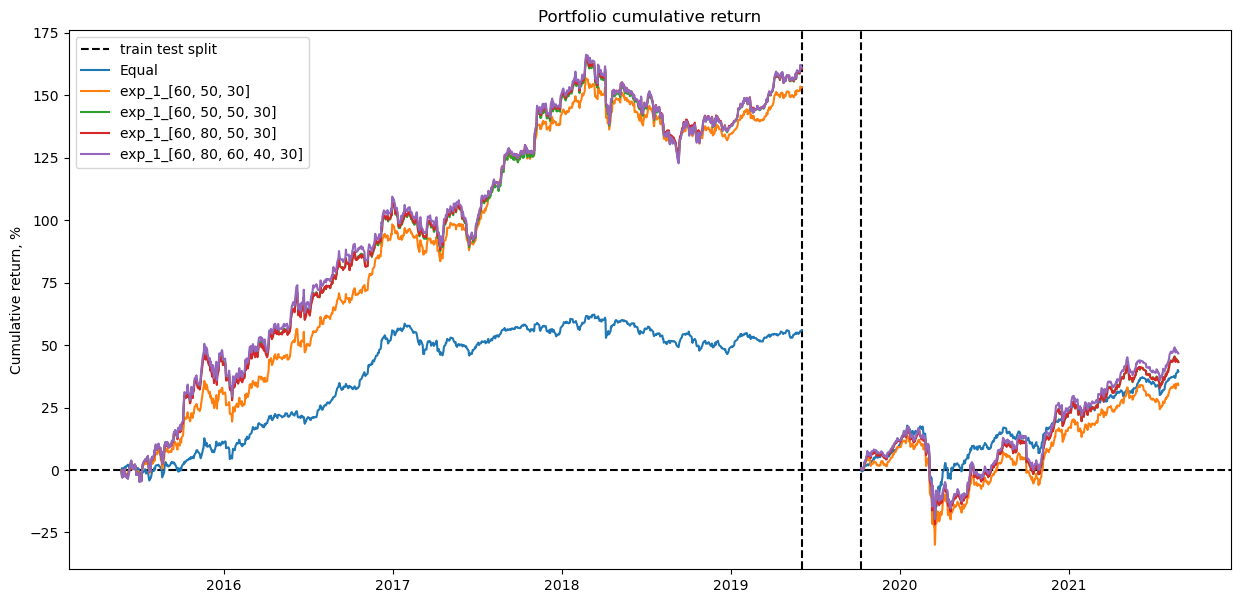

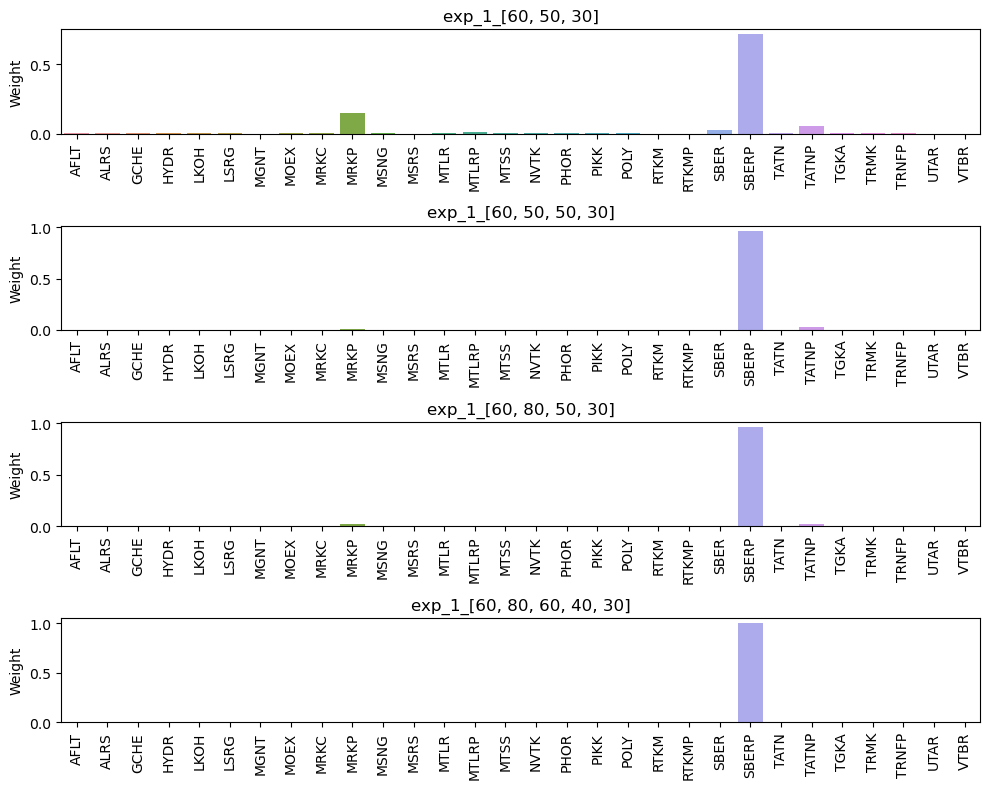

In [12]:
N_EPOCHS = 25
dataset_params = (TargetType.NEXT_RETURN, [FeaturesType.MEAN_RETURNS, FeaturesType.STDS], {})
train_loader, val_loader = get_loaders(dataset_params)
baseline_w, val_returns, total_mean_returns = get_baseline_w_and_returns(train_loader, val_loader)
FEATURES_SIZE = get_features_size(val_loader)
assert total_mean_returns is None

strategies = []

for layer_sizes in get_layer_sizes(FEATURES_SIZE):
    model = get_net(layer_sizes)
    optimizer, scheduler = get_optimizer_scheduler(model)

    criterion = ReturnCriterion()
    baseline_loss = criterion(baseline_w, val_returns).item()

    name = f'exp_1_{layer_sizes}'
    print_experiment(N_EPOCHS, baseline_loss, model, criterion)

    model = run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, N_EPOCHS, name)

    strategies.append(get_strategy(model, dataset_params, name))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/Experiment_1', use_cache=False)

# Experiment 2

Признаки: прошлые средние return

Критерий: ReturnCriterion(Q, total_mean_returns=None)


SigmaMinusReturnConstantWeights: val=0.0077%; train=0.0018%; baseline=0.0069
Train time: 0.092s; val time: 0.013s


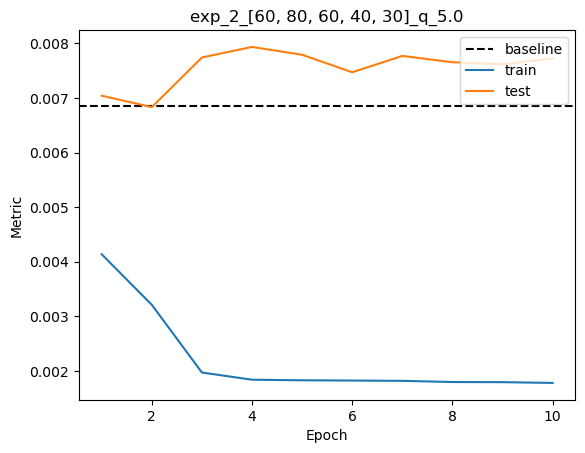

Success
Train: 1010. Test: 472
Features: torch.Size([32, 60]). Targets: torch.Size([32, 90, 30])
exp_2_[60, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              8.69% ± 9.42%  13.93% ± 12.00%  28.33% ± 14.01%  21.06% ± 18.24%
sharpe ratio             0.922268         1.161015         2.021714         1.154165
difference         -5.24% ± 6.91%    0.00% ± 0.00%    7.27% ± 8.31%    0.00% ± 0.00%
information ratio       -0.758087              NaN         0.874659              NaN

exp_2_[60, 50, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              8.57% ± 9.36%  13.93% ± 12.00%  27.94% ± 14.10%  21.06% ± 18.24%
sharpe ratio             0.915901         1.161015         1.981291         1.154165
difference         -5.36% ± 6.98%    0.00% ± 0.00%    6.88% ± 8.26%    0.00% ± 0.00%
information ratio       -0.767022              NaN         0.833349              Na

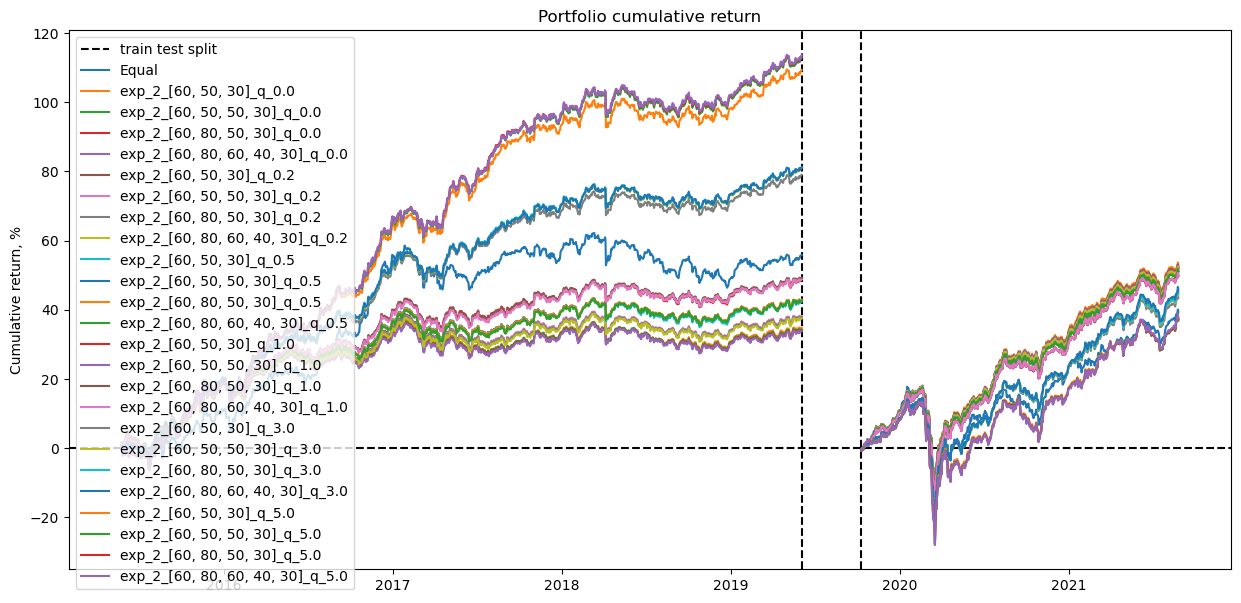

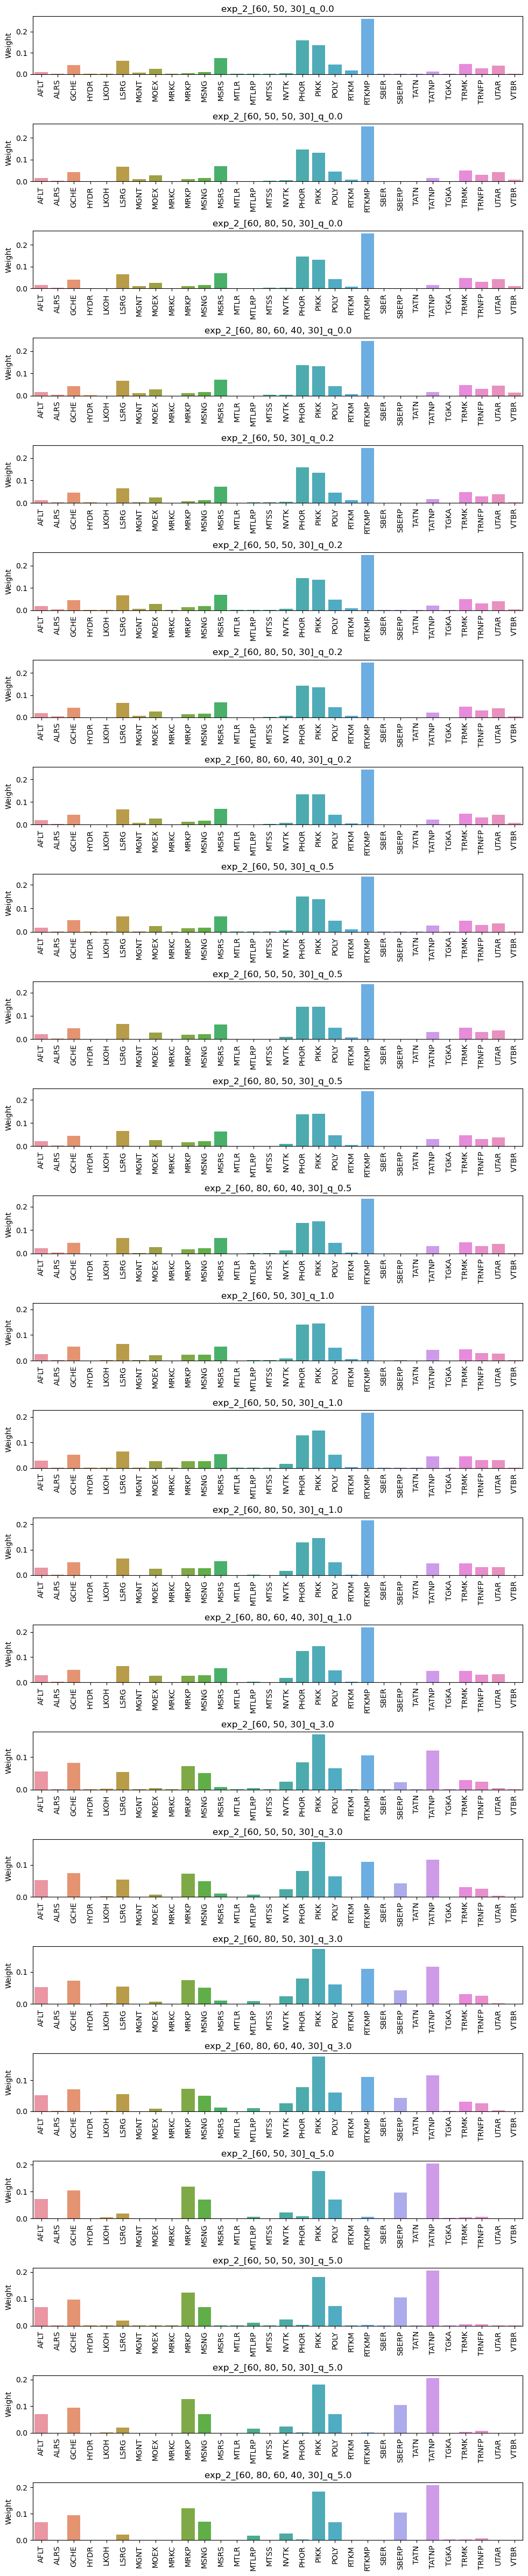

In [13]:
N_EPOCHS = 10
dataset_params = (TargetType.NEXT_RETURNS, [FeaturesType.MEAN_RETURNS, FeaturesType.STDS], {})
train_loader, val_loader = get_loaders(dataset_params)
baseline_w, val_returns, total_mean_returns = get_baseline_w_and_returns(train_loader, val_loader)
FEATURES_SIZE = get_features_size(val_loader)
assert total_mean_returns is not None

strategies = []

for q in get_q():
    for layer_sizes in get_layer_sizes(FEATURES_SIZE):
        model = get_net(layer_sizes)
        optimizer, scheduler = get_optimizer_scheduler(model)

        criterion = SigmaMinusReturnConstantWeights(q=q, total_mean_returns=None)
        baseline_loss = criterion(baseline_w, val_returns).item()

        print_experiment(N_EPOCHS, baseline_loss, model, criterion)

        name = f'exp_2_{layer_sizes}_q_{q}'
        model = run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, N_EPOCHS, name)

        strategies.append(get_strategy(model, dataset_params, name))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/Experiment_2', use_cache=False)

# Experiment 3

Признаки: прошлые средние return

Критерий: ReturnCriterion(Q, total_mean_returns)


SigmaMinusReturnConstantWeights: val=0.0054%; train=0.0019%; baseline=0.0077
Train time: 0.187s; val time: 0.017s


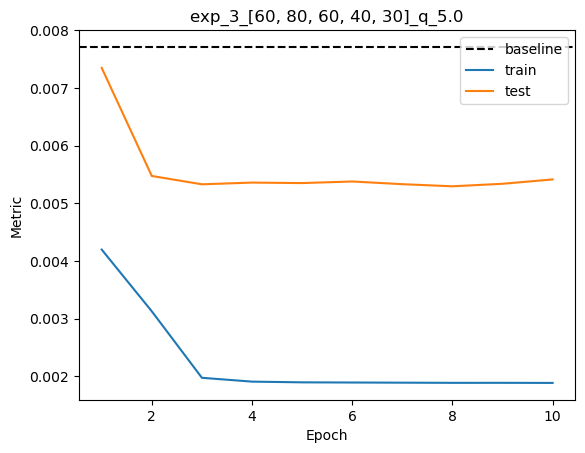

Success
Train: 1010. Test: 472
Features: torch.Size([32, 60]). Targets: torch.Size([32, 90, 30])
exp_3_[60, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              8.67% ± 9.42%  13.93% ± 12.00%  28.33% ± 14.01%  21.06% ± 18.24%
sharpe ratio             0.920582         1.161015         2.021626         1.154165
difference         -5.26% ± 6.93%    0.00% ± 0.00%    7.27% ± 8.33%    0.00% ± 0.00%
information ratio       -0.758604              NaN         0.873305              NaN

exp_3_[60, 50, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              8.57% ± 9.36%  13.93% ± 12.00%  27.94% ± 14.10%  21.06% ± 18.24%
sharpe ratio             0.915901         1.161015         1.981291         1.154165
difference         -5.36% ± 6.98%    0.00% ± 0.00%    6.88% ± 8.26%    0.00% ± 0.00%
information ratio       -0.767022              NaN         0.833349              Na

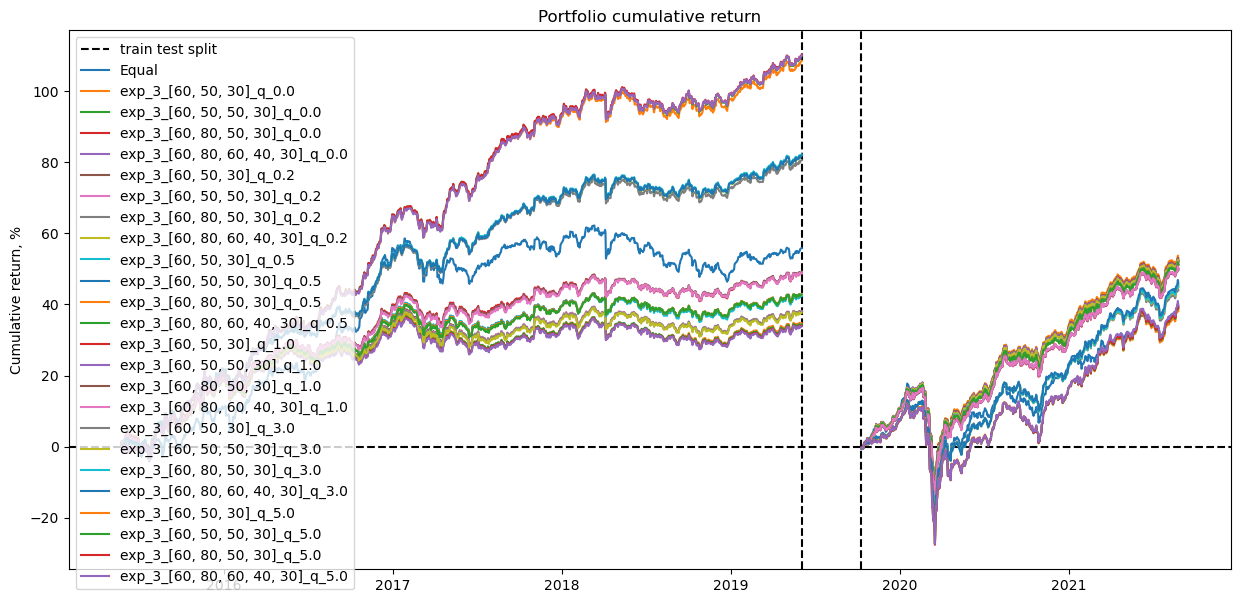

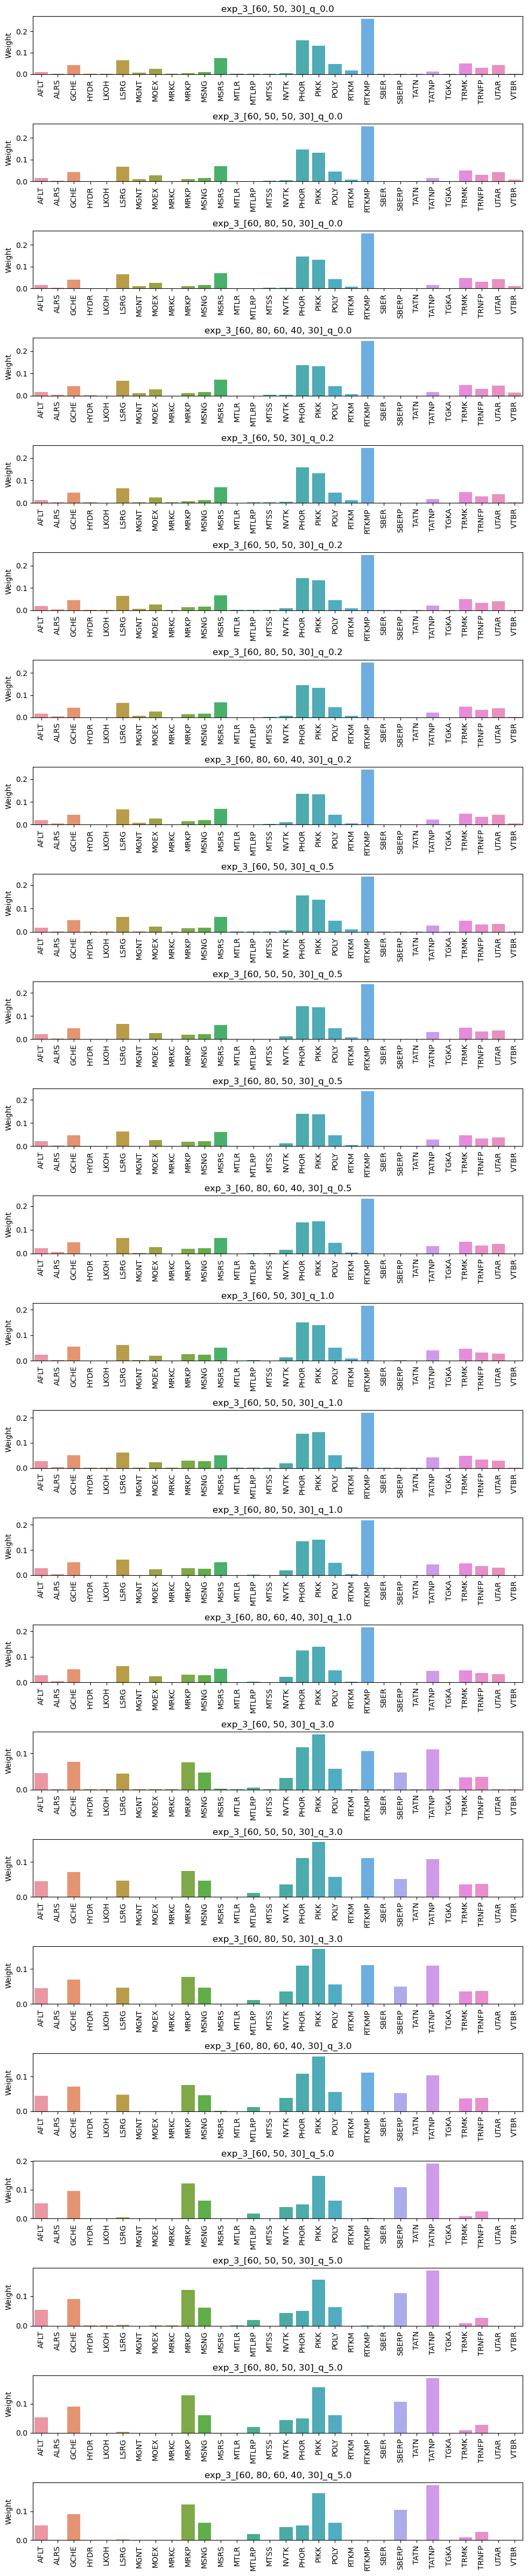

In [14]:
N_EPOCHS = 10
dataset_params = (TargetType.NEXT_RETURNS, [FeaturesType.MEAN_RETURNS, FeaturesType.STDS], {})
train_loader, val_loader = get_loaders(dataset_params)
baseline_w, val_returns, total_mean_returns = get_baseline_w_and_returns(train_loader, val_loader)
FEATURES_SIZE = get_features_size(val_loader)
assert total_mean_returns is not None

strategies = []

for q in get_q():
    for layer_sizes in get_layer_sizes(FEATURES_SIZE):
        model = get_net(layer_sizes)
        optimizer, scheduler = get_optimizer_scheduler(model)

        criterion = SigmaMinusReturnConstantWeights(q=q, total_mean_returns=total_mean_returns)
        baseline_loss = criterion(baseline_w, val_returns).item()

        print_experiment(N_EPOCHS, baseline_loss, model, criterion)

        name = f'exp_3_{layer_sizes}_q_{q}'
        model = run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, N_EPOCHS, name)

        strategies.append(get_strategy(model, dataset_params, name))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/Experiment_3', use_cache=False)

# Experiment 4


2 эксперимент, но мы добавляем еще и матрицу корреляций

SigmaMinusReturnConstantWeights: val=0.0070%; train=0.0010%; baseline=0.0069
Train time: 0.110s; val time: 0.022s


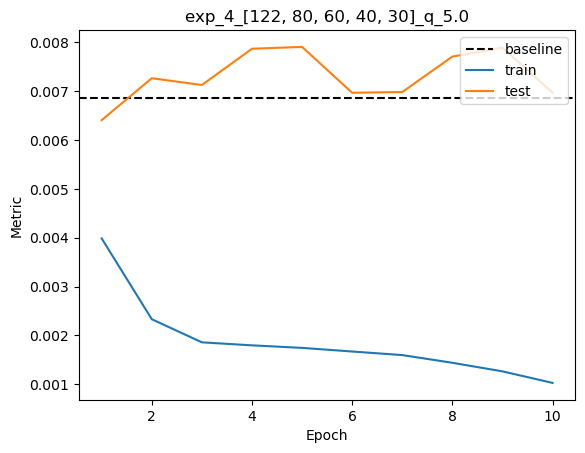

Success
Train: 1010. Test: 472
Features: torch.Size([32, 122]). Targets: torch.Size([32, 90, 30])
exp_4_[122, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              8.78% ± 9.19%  13.93% ± 12.00%  26.84% ± 13.74%  21.06% ± 18.24%
sharpe ratio             0.955317         1.161015         1.953283         1.154165
difference         -5.15% ± 6.97%    0.00% ± 0.00%    5.78% ± 8.69%    0.00% ± 0.00%
information ratio       -0.739456              NaN         0.665194              NaN

exp_4_[122, 50, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              8.78% ± 9.21%  13.93% ± 12.00%  25.74% ± 14.37%  21.06% ± 18.24%
sharpe ratio              0.95299         1.161015         1.791589         1.154165
difference         -5.15% ± 7.11%    0.00% ± 0.00%    4.69% ± 8.24%    0.00% ± 0.00%
information ratio       -0.724632              NaN         0.568331             

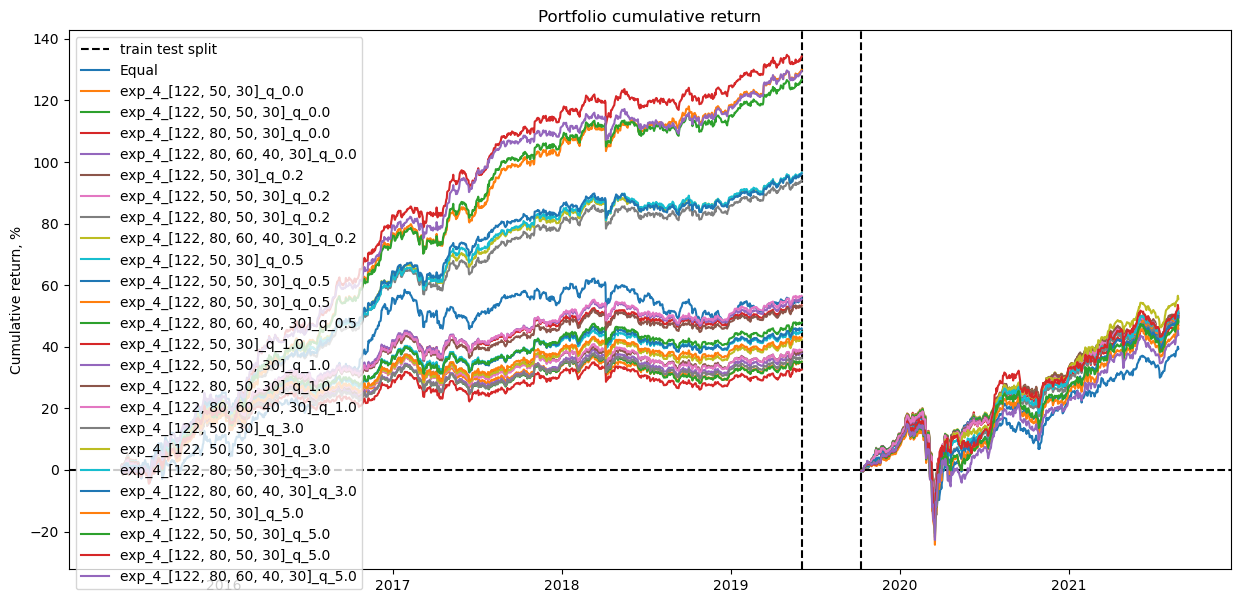

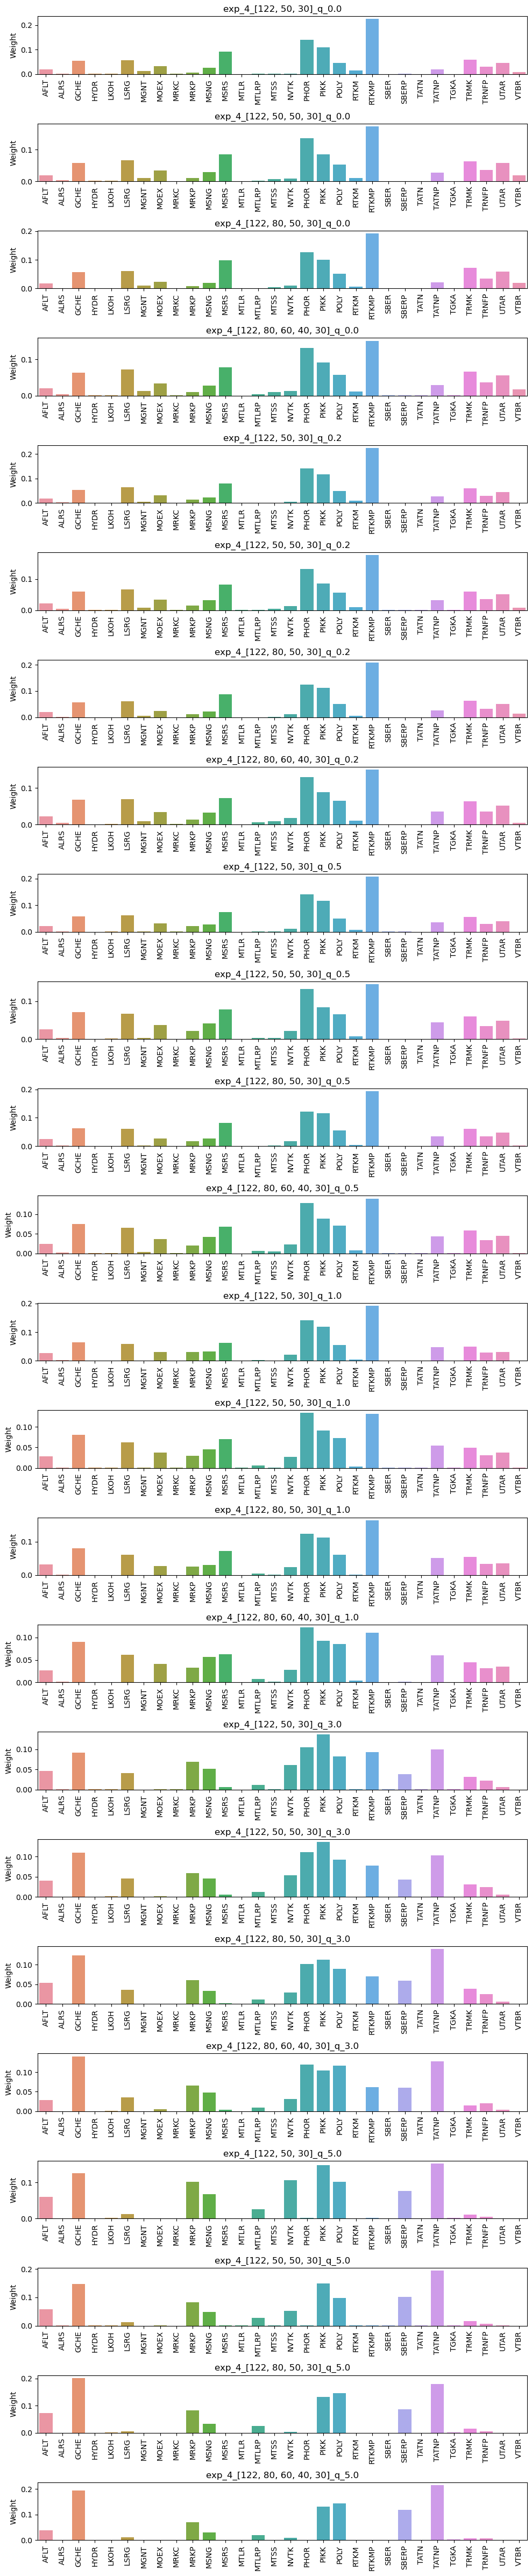

In [15]:
N_EPOCHS = 10
dataset_params = (TargetType.NEXT_RETURNS, [FeaturesType.MEAN_RETURNS, FeaturesType.STDS, FeaturesType.CORRELATION_MATRIX], {'corr_type': 'Sigma_svd', 'vectors_numbers': [0, 1]})
train_loader, val_loader = get_loaders(dataset_params)
baseline_w, val_returns, total_mean_returns = get_baseline_w_and_returns(train_loader, val_loader)
FEATURES_SIZE = get_features_size(val_loader)
assert total_mean_returns is not None

strategies = []

for q in get_q():
    for layer_sizes in get_layer_sizes(FEATURES_SIZE):
        model = get_net(layer_sizes)
        optimizer, scheduler = get_optimizer_scheduler(model)

        criterion = SigmaMinusReturnConstantWeights(q=q, total_mean_returns=None)
        baseline_loss = criterion(baseline_w, val_returns).item()

        print_experiment(N_EPOCHS, baseline_loss, model, criterion)

        name = f'exp_4_{layer_sizes}_q_{q}'
        model = run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, N_EPOCHS, name)

        strategies.append(get_strategy(model, dataset_params, name))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/Experiment_4', use_cache=False)

# Experiment 5

Обучаемся максимизировать метрику на всем датасете

SigmaMinusReturnConstantWeights: val=0.0080%; train=0.0021%; baseline=0.0073
Train time: 0.030s; val time: 0.007s


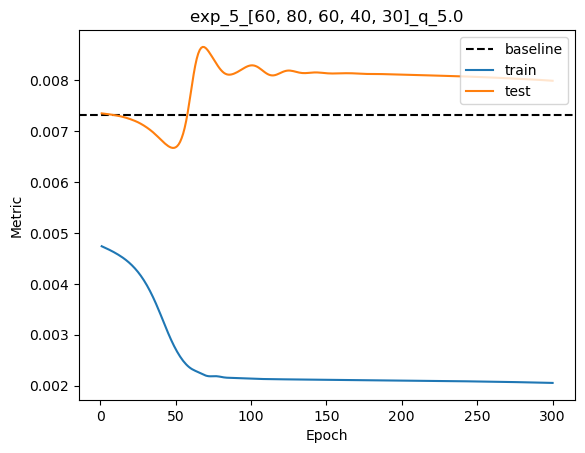

Success
Train: 1010. Test: 472
Features: torch.Size([32, 60]). Targets: torch.Size([32, 30])
exp_5_[60, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              9.78% ± 9.33%  13.93% ± 12.00%  27.45% ± 14.39%  21.06% ± 18.24%
sharpe ratio             1.047862         1.161015         1.907208         1.154165
difference         -4.15% ± 6.69%    0.00% ± 0.00%    6.39% ± 7.79%    0.00% ± 0.00%
information ratio       -0.620199              NaN         0.820245              NaN

exp_5_[60, 50, 50, 30]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              9.22% ± 9.27%  13.93% ± 12.00%  27.16% ± 14.45%  21.06% ± 18.24%
sharpe ratio             0.994314         1.161015         1.879068         1.154165
difference         -4.71% ± 6.81%    0.00% ± 0.00%    6.10% ± 7.80%    0.00% ± 0.00%
information ratio       -0.691482              NaN         0.782248              NaN

e

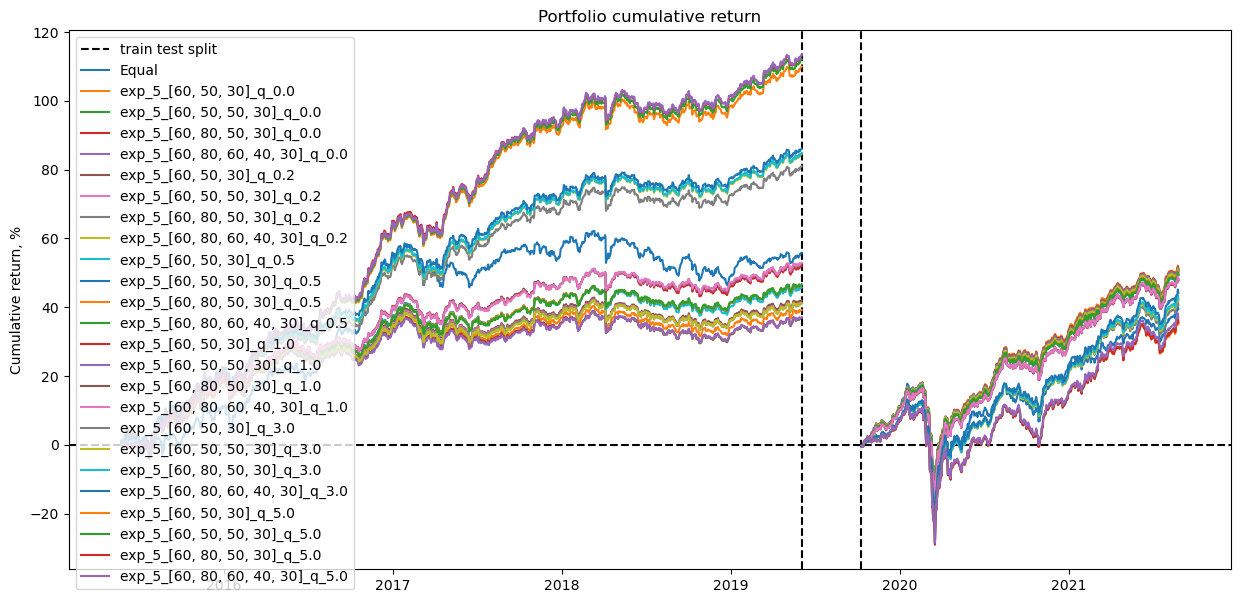

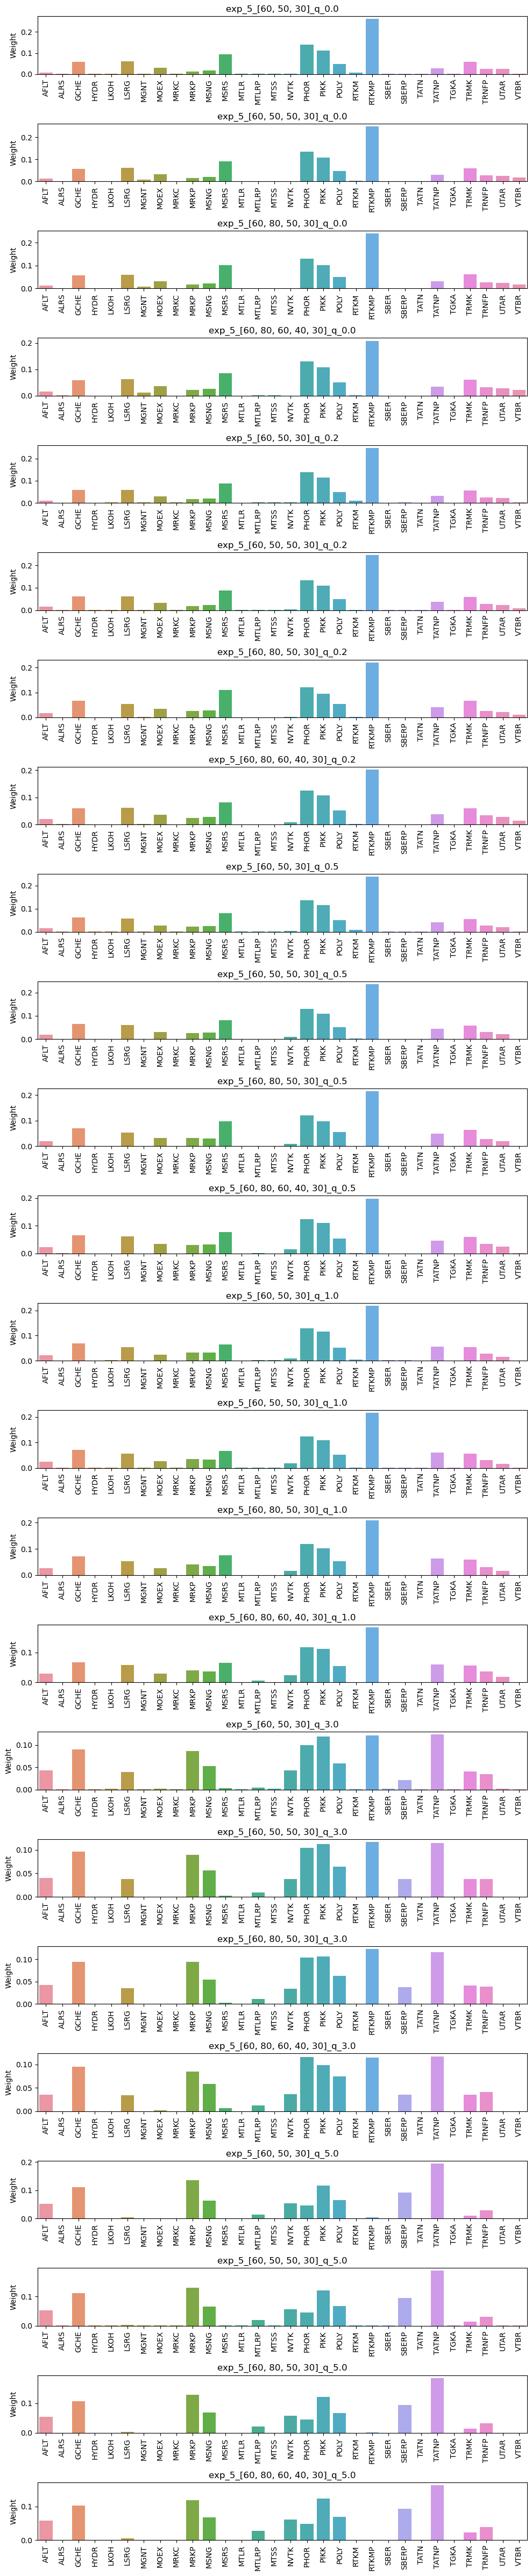

In [120]:
N_EPOCHS = 300
dataset_params = (TargetType.NEXT_RETURN, [FeaturesType.MEAN_RETURNS, FeaturesType.STDS], {})
train_loader, val_loader = get_loaders(dataset_params, batch_size=1024)
baseline_w, val_returns, total_mean_returns = get_baseline_w_and_returns(train_loader, val_loader)
FEATURES_SIZE = get_features_size(val_loader)
assert total_mean_returns is None

strategies = []

for q in get_q():
    for layer_sizes in get_layer_sizes(FEATURES_SIZE):
        model = get_net(layer_sizes)
        optimizer, scheduler = get_optimizer_scheduler(model)

        criterion = SigmaMinusReturnOnAllData(q=q)
        baseline_loss = criterion(baseline_w, val_returns).item()

        print_experiment(N_EPOCHS, baseline_loss, model, criterion)

        name = f'exp_5_{layer_sizes}_q_{q}'
        model = run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, N_EPOCHS, name)

        strategies.append(get_strategy(model, dataset_params, name))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/Experiment_5', use_cache=False)

# Experiment 6

Оптимизация по Марковицу

SigmaMinusReturnConstantWeights: val=0.0091%; train=0.0059%; baseline=0.0105
Train time: 20.339s; val time: 8.181s


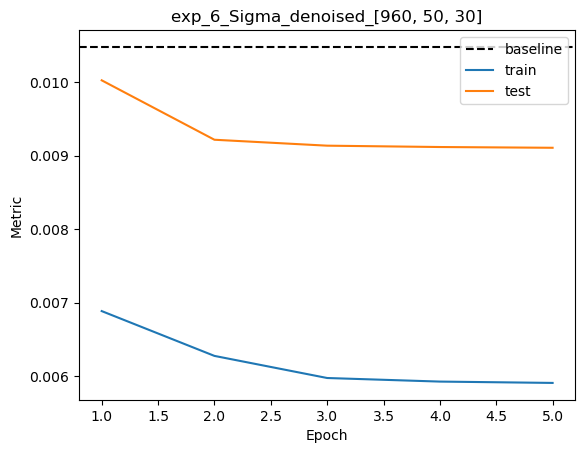

Success
Train: 1010. Test: 472
Features: torch.Size([32, 960]). Targets: torch.Size([32, 90, 30])
exp_6_Sigma_[960, 50, 30]
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return             6.15% ± 10.02%  13.93% ± 12.00%  27.53% ± 15.10%  21.06% ± 18.24%
sharpe ratio             0.613555         1.161015         1.822747         1.154165
difference         -7.78% ± 8.44%    0.00% ± 0.00%   6.47% ± 11.23%    0.00% ± 0.00%
information ratio       -0.922192              NaN           0.5765              NaN

exp_6_Sigma_denoised_[960, 50, 30]
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              7.72% ± 9.67%  13.93% ± 12.00%  29.67% ± 14.60%  21.06% ± 18.24%
sharpe ratio             0.797713         1.161015         2.031857         1.154165
difference         -6.21% ± 8.48%    0.00% ± 0.00%   8.61% ± 11.79%    0.00% ± 0.00%
information ratio       -0.732748              NaN          0.73029        

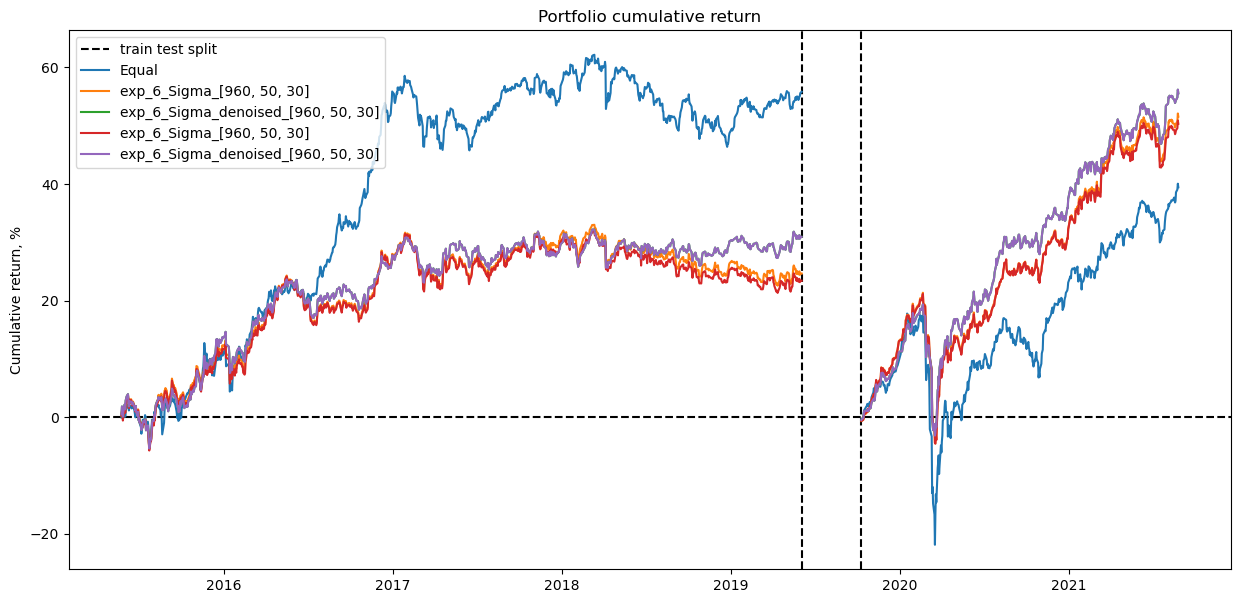

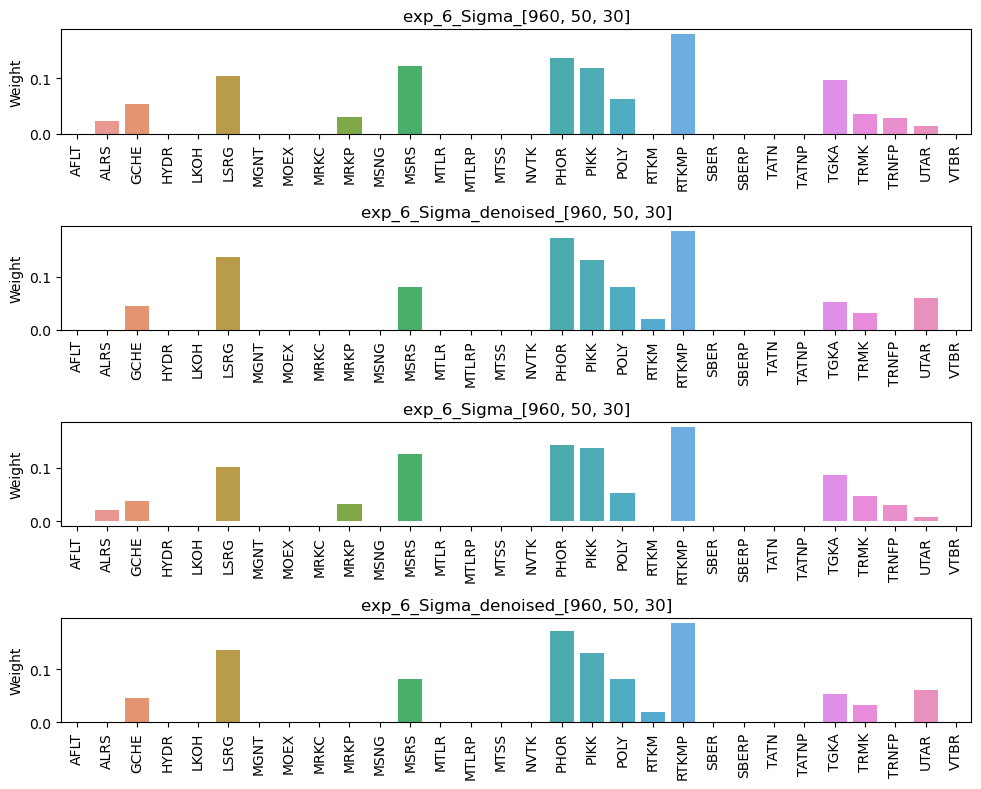

In [20]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer


class MarkowitzOptimizationLayer(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, Sigma, r_estimated):
        batch_size = Sigma.size()[0]
        assert r_estimated.size()[0] == batch_size
        results = []
        for i in range(batch_size):
            w = cp.Variable(N_ASSETS)
            r = cp.Parameter(N_ASSETS)
            constraints = [w >= 0, w @ torch.ones(N_ASSETS, dtype=torch.float32) == 1]
            objective = cp.Minimize(w @ Sigma[i] @ w - w @ r)

            problem = cp.Problem(objective, constraints)
            assert problem.is_dpp()
            cvxpylayer = CvxpyLayer(problem, parameters=[r], variables=[w])

            result = cvxpylayer(r_estimated[i])
            assert len(result) == 1 and result[0].dim() == 1
            results.append(result[0].unsqueeze(dim=0))
        return torch.concat(results, dim=0)


class MarkowitzNet(nn.Module):
    def __init__(self, layer_sizes: list[int]):
        super().__init__()
        layer_sizes = layer_sizes.copy()
        layer_sizes[0] -= N_ASSETS * N_ASSETS
        args = []
        for i in range(1, len(layer_sizes) - 1):
            args += [nn.Linear(layer_sizes[i - 1], layer_sizes[i]), nn.ReLU()]
        args += [nn.Linear(layer_sizes[-2], layer_sizes[-1])]
        self.net = nn.Sequential(
            *args
        )
        self.markowitz = MarkowitzOptimizationLayer()

    def forward(self, x):
        Sigma = x[:, :N_ASSETS * N_ASSETS].reshape((-1, N_ASSETS, N_ASSETS))
        x = x[:, N_ASSETS * N_ASSETS:]
        r_estimated = self.net(x)
        assert Sigma.size()[0] == r_estimated.size()[0]
        return self.markowitz(Sigma, r_estimated)


for corr_type in ['Sigma', 'Sigma_denoised']:
    N_EPOCHS = 5
    dataset_params = (TargetType.NEXT_RETURNS, [FeaturesType.CORRELATION_MATRIX, FeaturesType.STDS, FeaturesType.MEAN_RETURNS], {'corr_type': corr_type})
    train_loader, val_loader = get_loaders(dataset_params)
    baseline_w, val_returns, total_mean_returns = get_baseline_w_and_returns(train_loader, val_loader)
    FEATURES_SIZE = get_features_size(val_loader)
    assert total_mean_returns is not None

    layer_sizes = [FEATURES_SIZE, 50, 30]
    model = MarkowitzNet(layer_sizes=layer_sizes)
    optimizer, scheduler = get_optimizer_scheduler(model)

    criterion = SigmaMinusReturnConstantWeights(q=0.0, total_mean_returns=None)
    baseline_loss = criterion(baseline_w, val_returns).item()

    print_experiment(N_EPOCHS, baseline_loss, model, criterion)

    name = f'exp_6_{corr_type}_{layer_sizes}'
    model = run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, N_EPOCHS, name)

    strategies.append(get_strategy(model, dataset_params, name))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/Experiment_6', use_cache=False)

# Experiment 7

Оптимизация по кластерам

d:\anaconda3\envs\invest\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<AxesSubplot:>

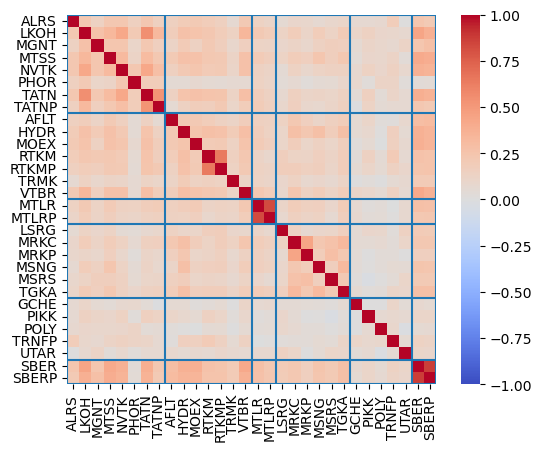

In [27]:
from library.correlations import get_returns_correlations
from library.clustering import get_distance_matrix, plot_correlation_matrix_clusters
from sklearn.cluster import KMeans


Sigma_train = get_returns_correlations(df_price_train).corr
dist_matrix = get_distance_matrix(Sigma_train)
cluster_labels = KMeans(n_clusters=6, random_state=0).fit_predict(dist_matrix)
plot_correlation_matrix_clusters(Sigma_train, cluster_labels)

SigmaMinusReturnConstantWeights: val=0.0061%; train=0.0022%; baseline=0.0069
Train time: 0.403s; val time: 0.056s


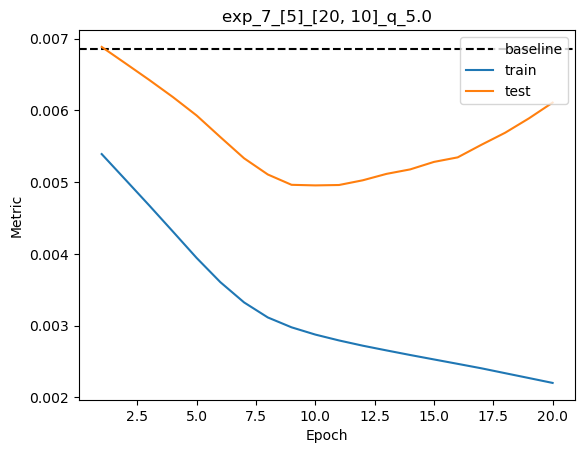

Success
Train: 1010. Test: 472
Features: torch.Size([32, 960]). Targets: torch.Size([32, 90, 30])
exp_7_[5]_[20, 10]_q_0.0
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              9.05% ± 9.43%  13.93% ± 12.00%  27.74% ± 14.28%  21.06% ± 18.24%
sharpe ratio             0.959219         1.161015         1.942424         1.154165
difference         -4.88% ± 6.63%    0.00% ± 0.00%    6.68% ± 7.76%    0.00% ± 0.00%
information ratio        -0.73644              NaN         0.860858              NaN

exp_7_[5]_[20, 10]_q_0.2
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              9.18% ± 9.43%  13.93% ± 12.00%  28.04% ± 14.18%  21.06% ± 18.24%
sharpe ratio             0.973458         1.161015         1.977126         1.154165
difference         -4.75% ± 6.67%    0.00% ± 0.00%    6.98% ± 7.95%    0.00% ± 0.00%
information ratio        -0.71263              NaN         0.877609              NaN



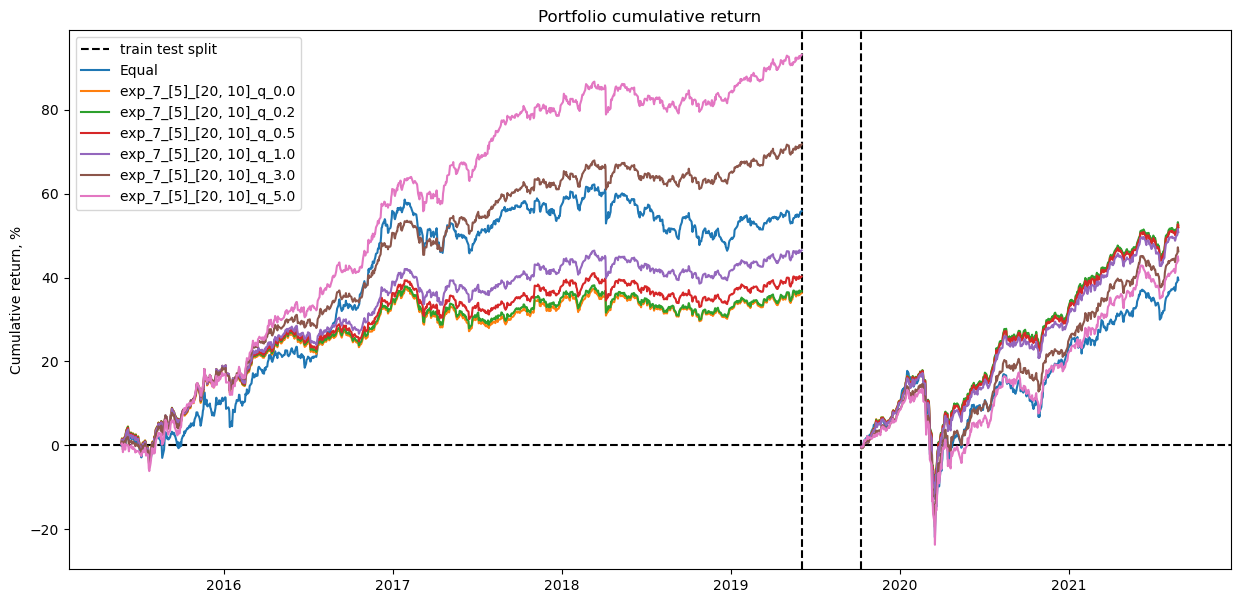

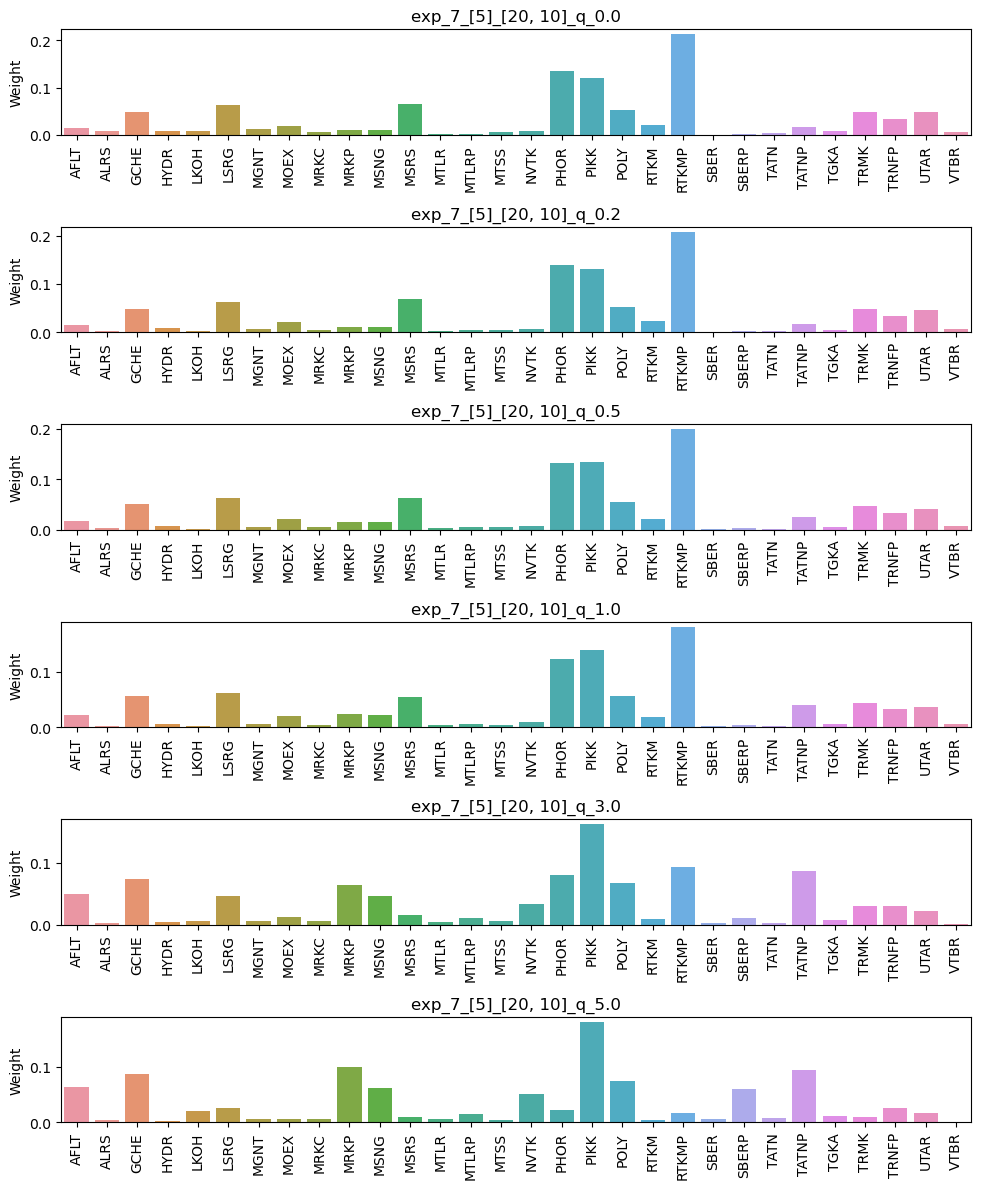

In [121]:
class ClusterNet(nn.Module):
    def __init__(self, cluster_labels: np.array, inner_sizes: list[int], outer_sizes: list[int]):
        super().__init__()

        # compute helpers
        self.clusters = sorted(np.unique(cluster_labels))
        assert self.clusters == list(range(max(cluster_labels) + 1))
        self.clusters_masks = [cluster_labels == c for c in self.clusters]

        cluster_sizes = pd.value_counts(cluster_labels).sort_index()
        cluster_cumulative_sizes = np.cumsum([0] + cluster_sizes.tolist())

        # (pos in clusters array) -> (pos in features)
        self.cluster_pos_to_features_pos = [None] * len(cluster_labels)
        for i in range(len(cluster_labels)):
            cluster = cluster_labels[i]
            self.cluster_pos_to_features_pos[i] = cluster_cumulative_sizes[cluster]
            cluster_cumulative_sizes[cluster] += 1
        assert sorted(self.cluster_pos_to_features_pos) == list(range(len(cluster_labels)))

        # initialize inner nets and outer net
        self.inner_nets = nn.ModuleList([Net(layer_sizes=[cluster_sizes[i] * 2] + inner_sizes + [cluster_sizes[i]]) for i in self.clusters])
        self.outer_net = Net([len(self.clusters) * 2] + outer_sizes + [len(self.clusters)])

    def forward(self, x):
        assert x.size()[-1] == N_ASSETS * N_ASSETS + 2 * N_ASSETS, x.size()
        # extract features
        Sigma_all = x[:, :N_ASSETS * N_ASSETS].reshape((-1, N_ASSETS, N_ASSETS))
        stds_all = x[:, N_ASSETS * N_ASSETS:N_ASSETS * N_ASSETS + N_ASSETS].reshape((-1, N_ASSETS))
        means_all = x[:, N_ASSETS * N_ASSETS + N_ASSETS:]
        assert stds_all.size() == means_all.size()
        # compute covariance matrix
        Sigma_cov = stds_all.unsqueeze(dim=2) * Sigma_all * stds_all.unsqueeze(dim=1)
        # remove covariance matrix from features
        x = x[:, N_ASSETS * N_ASSETS:]
        # compute inner weights and statistics
        weights_inner = []  # list of (BATCH_SIZE, cluster_size), len = n_clusters
        stds_inner = []  # list of (BATCH_SIZE, 1), len = n_clusters
        means_inner = []  # list of (BATCH_SIZE, 1), len = n_clusters
        for c in self.clusters:
            # get mask for cluster
            cluster_mask = self.clusters_masks[c]
            # extract statistics for cluster
            Sigma_cov_cluster = Sigma_cov[:, cluster_mask][:, :, cluster_mask]  # (BATCH_SIZE, cluster_size, cluster_size)
            stds_cluster = stds_all[:, cluster_mask]  # (BATCH_SIZE, cluster_size)
            means_cluster = means_all[:, cluster_mask]  # (BATCH_SIZE, cluster_size)
            # apply inner Net
            input_inner = torch.concat((stds_cluster, means_cluster), dim=-1)
            weight_inner = self.inner_nets[c](input_inner)  # (BATCH_SIZE, cluster_size)
            weights_inner.append(weight_inner)
            # compute mean in cluster
            mean_inner = (means_cluster * weight_inner).sum(dim=-1).unsqueeze(dim=-1)  # (BATCH_SIZE, 1)
            means_inner.append(mean_inner)
            # compute std in cluster
            std_inner = torch.bmm(torch.bmm(weight_inner.unsqueeze(dim=1), Sigma_cov_cluster), weight_inner.unsqueeze(dim=2)).squeeze(dim=-1)  # (BATCH_SIZE, 1)
            stds_inner.append(std_inner)
        # construct input for outer Net
        means_inner = torch.concat(means_inner, dim=-1)  # (BATCH_SIZE, n_clusters)
        stds_inner = torch.concat(stds_inner, dim=-1)  # (BATCH_SIZE, n_clusters)
        input_outer = torch.concat((stds_inner, means_inner), dim=-1)
        # apply outer Net
        weights_outer = self.outer_net(input_outer)  # (BATCH_SIZE, n_clusters)
        # compute weights for all assets
        weights_all = []
        for c in self.clusters:
            weights_all.append(weights_inner[c] * weights_outer[:, c].unsqueeze(dim=-1))
        weights_all = torch.concat(weights_all, dim=-1)
        # rearrange back
        weights_all = weights_all[:, self.cluster_pos_to_features_pos]
        return weights_all


strategies = []

for q in get_q():
    N_EPOCHS = 20
    dataset_params = (TargetType.NEXT_RETURNS, [FeaturesType.CORRELATION_MATRIX, FeaturesType.STDS, FeaturesType.MEAN_RETURNS], {'corr_type': 'Sigma'})
    train_loader, val_loader = get_loaders(dataset_params)
    baseline_w, val_returns, total_mean_returns = get_baseline_w_and_returns(train_loader, val_loader)
    FEATURES_SIZE = get_features_size(val_loader)
    assert total_mean_returns is not None

    inner_sizes = [5]
    outer_sizes = [20, 10]
    model = ClusterNet(cluster_labels, inner_sizes=inner_sizes, outer_sizes=outer_sizes)
    optimizer, scheduler = get_optimizer_scheduler(model)

    criterion = SigmaMinusReturnConstantWeights(q, total_mean_returns=None)
    baseline_loss = criterion(baseline_w, val_returns).item()

    print_experiment(N_EPOCHS, baseline_loss, model, criterion)

    name = f'exp_7_{inner_sizes}_{outer_sizes}_q_{q}'
    model = run_experiment(model, optimizer, criterion, scheduler, train_loader, val_loader, baseline_loss, N_EPOCHS, name)

    strategies.append(get_strategy(model, dataset_params, name))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/Experiment_7', use_cache=False)